# Load data and dependancies

In [ ]:
!pip install krovetzstemmer
import os
os.chdir("./Text summarization")
from imports import *
from Preprocess import *
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english')) 

## Data preparation

The dataset is the CNN news-highlights dataset, which contains news articles and associated highlights, which will serve as a summary. 
\
P.S: the highlights are manually written summaries and not selected sentencs from the original article.

https://drive.google.com/uc?export=download&id=0BwmD_VLjROrfTHk4NFg2SndKcjQ

First, we will load the data (stories and summaries, then store them into a .csv file).
\
the data needs to be extracted from the archive file into the project directory. There is a folder named processed which contains 2 subfolders: one for the stories and the other for the summaries. Each article is stored in a text file has its corresponding summary. 

In [ ]:
#project directory
os.chdir("./Text summarization)
#stories directory
pa1=os.listdir("./data/stories")
#summaries directory
pa2=os.listdir("./data/summaries")
articles=open_stories(pa1)
summaries=open_summaries(pa2)

#store data to .csv file
data=pd.DataFrame(columns =[ 'article_text', 'abstract_text'])
for i in range(len(articles)):
    data=data.append([{'article_text' : articles[i], 'abstract_text' : summaries[i]}])
data.to_csv('./data/Text summarization data.csv',index=False)

You can download the csv file directly from this link
https://drive.google.com/file/d/1sPuibHPMxR8apDfPSGyqd5DqTC7wzCRs/view?usp=sharing

In [ ]:
data.head()

,article_text,summary_text
0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...
1,Usain Bolt rounded off the world championships...,Usain Bolt wins third gold of world championsh...
2,"The General Services Administration, already u...",The employee in agency's Kansas City office is...
3,"A medical doctor in Vancouver, British Columbi...",NEW: A Canadian doctor says she was part of a ...
4,"Police arrested another teen Thursday, the six...",Another arrest made in gang rape outside Calif...


# Data Analysis & preprocessing

For both articles and summariesn we add features:
1. Number of characters
2. Number of words
3. Number of sentences

In [ ]:
data["article_character_count"]=data.article_text.apply(len)
data["article_word_count"]=data.article_text.apply(num_tokens_without_punctuation)
sentence_tokens= data.article_text.apply(sentence_tokenizer)
data["article_sentence_count"]=[element[1] for element in sentence_tokens]

In [ ]:
data["summary_character_count"]=data.summary_text.apply(len)
data["summary_word_count"]=data.article_text.apply(num_tokens_without_punctuation)
summary_sentence_tokens= data.summary_text.apply(sentence_tokenizer)
data["summary_sentence_count"]=[element[1] for element in summary_sentence_tokens]

Save the data into .pkl file to avoid runing the process each time

In [ ]:
with open('data/corpus_dataframe.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
data.head()

,article_text,summary_text,article_character_count,article_word_count,article_sentence_count,summary_character_count,summary_word_count,summary_sentence_count
0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,9442,1521,66,297,1521,4
1,Usain Bolt rounded off the world championships...,Usain Bolt wins third gold of world championsh...,3203,520,19,181,520,4
2,"The General Services Administration, already u...",The employee in agency's Kansas City office is...,6191,1004,42,241,1004,3
3,"A medical doctor in Vancouver, British Columbi...",NEW: A Canadian doctor says she was part of a ...,5837,928,41,323,928,4
4,"Police arrested another teen Thursday, the six...",Another arrest made in gang rape outside Calif...,1681,286,14,213,286,3


## Data cleaning

Let us delete the articles with 2 or less sentences


Also some articles contain some dialogues/interviews: we delete an article just when we find more than 5 occurences of a Name starting with Capital letter and finished by ":", along side the root of word 'interview:' 



In [ ]:
data = filter_articles(data)
len(data)

90600

We have now 90600 articles after removing the irrelevant articles. Let us check some of the articles and their summary

In [ ]:
check_articles(data, 0, len(data) , 20)

Article text: 
(CNN)Under harsh lights in a private, rented room in Berlin, women face each other in violent, sometimes bloody battles of brute strength.
There are no official rules to this female fight club. The fighters are both beginners and professionals, anywhere from age 20 to 50, said photographer Katarzyna Mazur, who spent months documenting the club in 2013 and 2014.
Led by founders nicknamed Anna Konda and Red Devil, a match might pit a bodybuilder against a martial arts master. They can wrestle, throw punches or "cat fight." There's no judge, just someone who knows the parameters they've decided for the match. The small audience is mostly made up of men, but it's a place for women to shed the roles they play outside.
"When I saw this kind of fighting for the first time, I was quite shocked. I had never seen something like that before, and it was really interesting to experience all of this so close," said Mazur, who photographed the fight club as part of her work toward grad

Some articles/summaries contain terms that need to be ignored in order to facilitate the summarizing learning task.

We will include the deletion of these terms in a preprocessing/cleaning pipeline for the text and summary at the same time.

In [ ]:
with open('data/transformations.json') as f:
  transformations = json.load(f)

In [ ]:
#Example:
article_text_example= data.loc[300,"article_text"]
print(article_text_example)

(CNN)In the gentle yet fiercely warm surrounds of the southern Ugandan countryside, Mwanja Banuli looks on as farmhands fill his truck with sugar cane.
Packing this rough, woody crop is heavy going and making sure every inch of space is utilized is key.
Transport costs money, after all, and this humble sugar farmer has lots of costs to consider.
"There are many challenges in this business," Banuli says. "Rent for our land costs about $300 and then you need to pay people to clear the land.
"You have to hire a tractor for ploughing and tilling the land. When you add up all these expenses, it's a big investment."
Searching for Sugarman
In Uganda, sugar is big business.
This particular batch is headed for Kakira Sugar Limited -- one of the country's oldest and largest factories.
Kakira was founded by Muljibai Madhvani, an immigrant from the Indian subcontinent in the late 1920s.
It's a company still going strong to this day.
"What you see in the background is the first mill that was instal

In [ ]:
##apply cleaning function on article
cleaned_article_text=clean_text(article_text_example, transformations)
print(cleaned_article_text)

 cnn in the gentle yet fiercely warm surrounds of the southern ugandan countryside mwanja banuli looks on as farmhands fill his truck with sugar cane. packing this rough woody crop is heavy going and making sure every inch of space is utilized is key. transport costs money after all and this humble sugar farmer has lots of costs to consider. there are many challenges in this business banuli says. rent for our land costs about $300 and then you need to pay people to clear the land. you have to hire a tractor for ploughing and tilling the land. when you add up all these expenses it is a big investment. searching for sugarman in uganda sugar is big business. this particular batch is headed for kakira sugar limited one of the country's oldest and largest factories. kakira was founded by muljibai madhvani an immigrant from the indian subcontinent in the late 1920s. it's a company still going strong to this day. what you see in the background is the first mill that was installed in 1930 to c

We will create a cleaned dataframe for each article containing:
1. The article text
2. The article summary
3. The character counts for the Text and the Summary
4. The sentence counts for the Text and the Summary
5. The word counts for the Text and the Summary

In [ ]:
text_summarization_preprocessed_data= pd.DataFrame(
  columns=['article_text','summary_text','article_character_count','article_word_count','article_sentence_count',
           'summary_character_count','summary_word_count	summary_sentence_count'])
t = time()
#create pre-processed data
text_summarization_preprocessed_data['article_text']= data["article_text"].apply(lambda x: clean_text(x, 
                                                              transformations))

text_summarization_preprocessed_data['summary_text']= data["summary_text"].apply(lambda x: clean_text(x, 
                                                              transformations))

print('Time to clean up articles and summaries: {} mins'.format(round((time() - t) / 60, 2)))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Time to clean up articles and summaries: 1.94 mins


In [ ]:
#summarize the results
text_summarization_preprocessed_data["article_character_count"]= text_summarization_preprocessed_data.article_text.apply(len)
text_summarization_preprocessed_data["article_word_count"]= text_summarization_preprocessed_data.article_text.apply(num_tokens_without_punctuation)
sentence_tokens= text_summarization_preprocessed_data.article_text.apply(sentence_tokenizer)
text_summarization_preprocessed_data["article_sentence_count"]=[element[1] for element in sentence_tokens]

text_summarization_preprocessed_data["summary_character_count"]= text_summarization_preprocessed_data.summary_text.apply(len)
text_summarization_preprocessed_data["summary_word_count"]= text_summarization_preprocessed_data.summary_text.apply(num_tokens_without_punctuation)
sentence_tokens= text_summarization_preprocessed_data.summary_text.apply(sentence_tokenizer)
text_summarization_preprocessed_data["summary_sentence_count"]=[element[1] for element in sentence_tokens]
text_summarization_preprocessed_data.head()

,article_text,summary_text,article_character_count,article_word_count,article_sentence_count,summary_character_count,summary_word_count\tsummary_sentence_count,summary_word_count,summary_sentence_count
0,usain bolt rounded off the world championships...,usain bolt wins third gold of world championsh...,3156,307,19,177,NaN,19,4
1,the general services administration already un...,the employee in agency's kansas city office is...,6080,546,39,234,NaN,21,2
2,a medical doctor in vancouver british columbia...,new: a canadian doctor says she was part of a ...,5715,529,37,315,NaN,35,3
3,police arrested another teen thursday the sixt...,another arrest made in gang rape outside calif...,1641,167,13,209,NaN,25,3
4,thousands on saturday fled the area in southwe...,humanitarian groups expect 4 000 refugees in o...,3427,309,25,215,NaN,20,3


In [ ]:
text_summarization_preprocessed_data.to_pickle("data/text_summarization_preprocessed_data.pkl")
with open('data/text_summarization_preprocessed_data.pkl', 'rb') as f:
    text_summarization_preprocessed_data = pickle.load(f)

## Distributions

We will plot the distribution of the different counts to verify if the summary keeps the overall shapes of the distributions.

In [ ]:
df_char_counts=pd.DataFrame({"Text_char":text_summarization_preprocessed_data["article_character_count"],"Summary_char":text_summarization_preprocessed_data["summary_character_count"]})
df_word_counts=pd.DataFrame({"Text_word":text_summarization_preprocessed_data["article_word_count"],"Summary_word":text_summarization_preprocessed_data["summary_word_count"]})
df_sentence_counts=pd.DataFrame({"Text_sentence":text_summarization_preprocessed_data["article_sentence_count"],"Summary_sentebnce":text_summarization_preprocessed_data["summary_sentence_count"]})

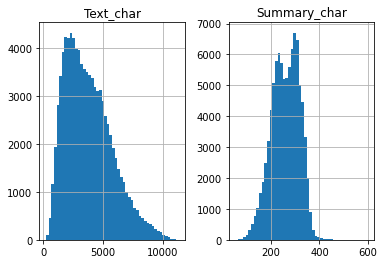

In [ ]:
#chacter count distrubution over the articles and their summaries

df_char_counts.hist(bins = 50)
plt.show()

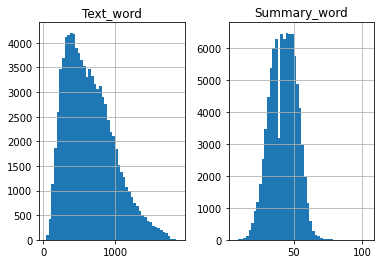

In [ ]:
#word count distrubution over the articles and their summaries
df_word_counts.hist(bins = 50)
plt.show()

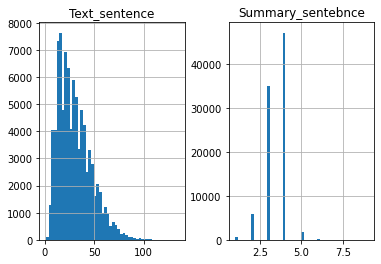

In [ ]:
#sentence count distrubution over the articles and their summaries
df_sentence_counts.hist(bins = 50)
plt.show()

The sentence counts have different distrubution shapes.
Since each summary generally contains only a few sentences (2-7), it is normal to obtain such distribution.

In [ ]:
#create dictionnaries: tokens, lemma, stems
stop_words=stopwords.words('english')
lemmatizer= WordNetLemmatizer()
stemmer= PorterStemmer()

t=time()
words_dict, stem_dict, lemma_dict=create_dictionaries(text_summarization_preprocessed_data["article_text"])

print('Total time for creating articles vocabulary: {:.2f} minutes'.format((time() - t)/60))

t=time()
words_summ_dict, stem_summ_dict, lemma_summ_dict=create_dictionaries(text_summarization_preprocessed_data["summary_text"])

print('Total time for creating summary vocabulary: {:.2f} minutes'.format((time() - t)/60))

0 articles proceeeded
10000 articles proceeeded
20000 articles proceeeded
30000 articles proceeeded
40000 articles proceeeded
50000 articles proceeeded
60000 articles proceeeded
70000 articles proceeeded
80000 articles proceeeded
90000 articles proceeeded
Total time for creating articles vocabulary: 22.53 minutes
0 articles proceeeded
10000 articles proceeeded
20000 articles proceeeded
30000 articles proceeeded
40000 articles proceeeded
50000 articles proceeeded
60000 articles proceeeded
70000 articles proceeeded
80000 articles proceeeded
90000 articles proceeeded
Total time for creating summary vocabulary: 1.81 minutes


In [ ]:
print('Tokens frequencies for the articles corpus:')
print('Words: '+ str(len(words_dict)))
print('stems: '+ str(len(stem_dict)))
print('lemmas: '+str(len(lemma_dict)))

Tokens frequencies for the articles corpus:
Words: 331451
stems: 260977
lemmas: 313575


In [ ]:
print('Tokens frequencies for the summaries corpus:')
print('Words: '+ str(len(words_summ_dict)))
print('stems: '+ str(len(stem_summ_dict)))
print('lemmas: '+str(len(lemma_summ_dict)))

Tokens frequencies for the summaries corpus:
Words: 89094
stems: 65085
lemmas: 80567


In [ ]:
#save texts vocabularies
with open("data/words_dict.pkl", 'wb') as f:
  pickle.dump(words_dict,f)
with open("data/stems_dict.pkl", 'wb') as f:
  pickle.dump(stem_dict,f)
with open("data/lemma_dict.pkl", 'wb') as f:
  pickle.dump(lemma_dict,f)

#save summaries vocabularies
with open("data/words_summ_dict.pkl", 'wb') as f:
  pickle.dump(words_summ_dict,f)
with open("data/stems_summ_dict.pkl", 'wb') as f:
  pickle.dump(stem_summ_dict,f)
with open("data/lemma_summ_dict.pkl", 'wb') as f:
  pickle.dump(lemma_summ_dict,f)

In [ ]:
#load dictionnaries
with open('data/words_dict.pkl', 'rb') as f:
    words_dict = pickle.load(f)
with open('data/stems_dict.pkl', 'rb') as f:
    stems_dict = pickle.load(f)
with open('data/lemma_dict.pkl', 'rb') as f:
    lemma_dict = pickle.load(f)

with open('data/words_summ_dict.pkl', 'rb') as f:
    words_summ_dict = pickle.load(f)
with open('data/stems_summ_dict.pkl', 'rb') as f:
    stems_summ_dict = pickle.load(f)
with open('data/lemma_summ_dict.pkl', 'rb') as f:
    lemma_summ_dict = pickle.load(f)

Next, the most frequent terms, stems and lemmas for the articles and summaries are stored and ploted by sorting their frequencies.

In [ ]:
freq_words_artciles= most_freq_terms(words_dict, n=15)
freq_lemmas_artciles=most_freq_terms(lemma_dict, n=15)
freq_stems_articles= most_freq_terms(stems_dict, n=15)
freq_words_summaries =most_freq_terms(words_summ_dict, n=15)
freq_lemmas_summaries=most_freq_terms(lemma_summ_dict, n=15)
freq_stems_summaries= most_freq_terms(stems_summ_dict, n=15)

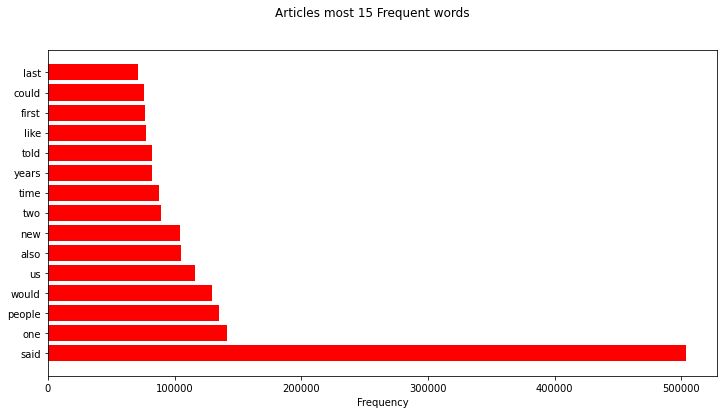

In [ ]:
n=15
plot_frequent_terms(words_dict, n,doc='Articles', term_='words')

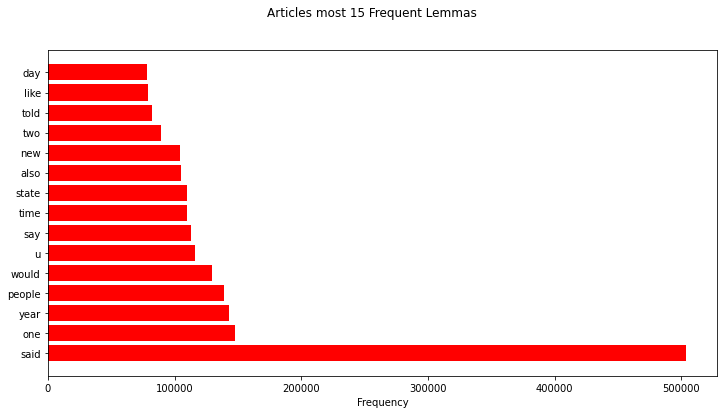

In [ ]:
plot_frequent_terms(lemma_dict, n,doc='Articles', term_='Lemmas')

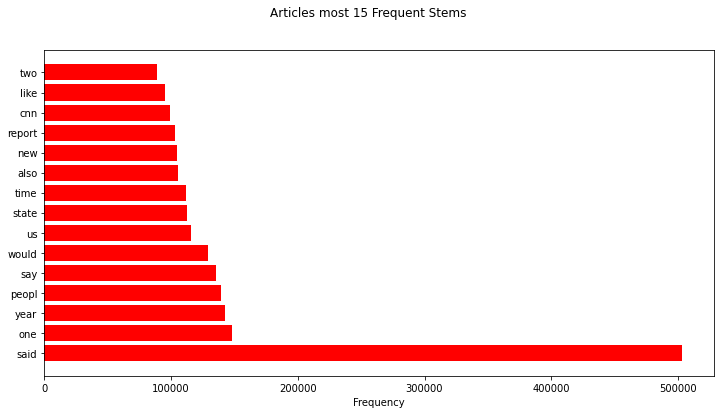

In [ ]:
plot_frequent_terms(stems_dict, n,doc='Articles', term_='Stems')

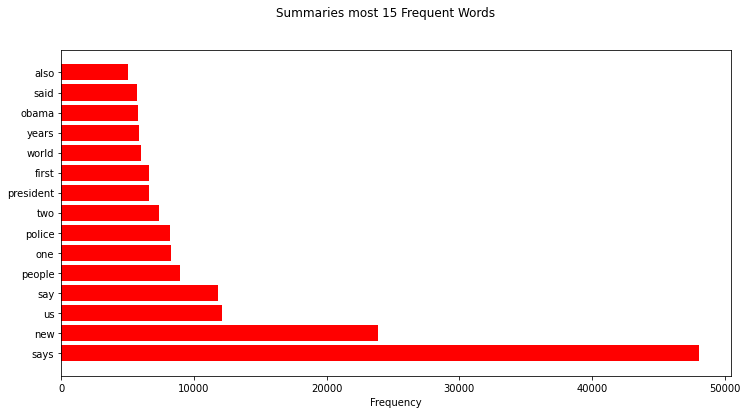

In [ ]:
plot_frequent_terms(words_summ_dict, n,doc='Summaries', term_='Words')

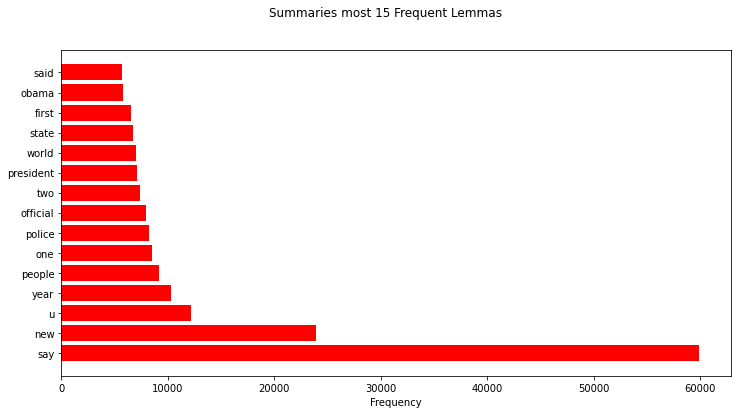

In [ ]:
plot_frequent_terms(lemma_summ_dict, n,doc='Summaries', term_='Lemmas')

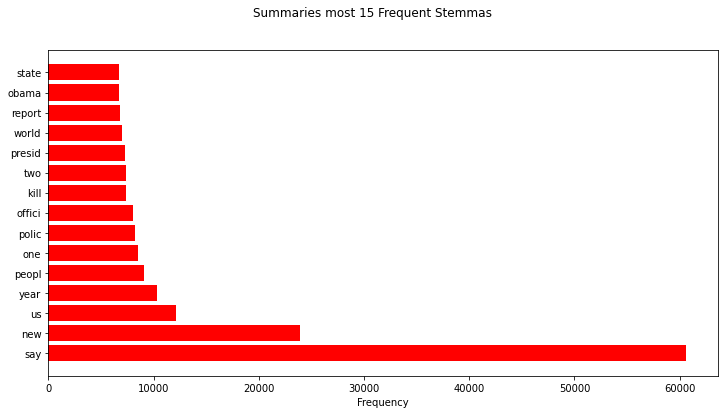

In [ ]:
plot_frequent_terms(stems_summ_dict, n,doc='Summaries', term_='Stemmas')